In [43]:
import torch
import torchvision
import lovely_tensors
lovely_tensors.monkey_patch()
from tqdm import tqdm

torch.set_grad_enabled(False)
%load_ext autoreload
%autoreload all

device = "cuda" if torch.cuda.is_available() else "cpu"
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'cuda'

In [39]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor

from pca import IncrementalPCA

batch_size = 1024
transform = Compose([ToTensor()])
dataset = CIFAR10('data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=False, num_workers=4)

pca = IncrementalPCA(n_components=1024, n_features=3*32*32).to(device)
for img, _label in tqdm(dataloader):
    img = img.view(img.size(0), -1).cuda()
    pca.partial_fit(img)

torch.save(pca.cpu().state_dict(), "pca_cifar.pt")

Files already downloaded and verified


100%|██████████| 49/49 [00:08<00:00,  5.66it/s]


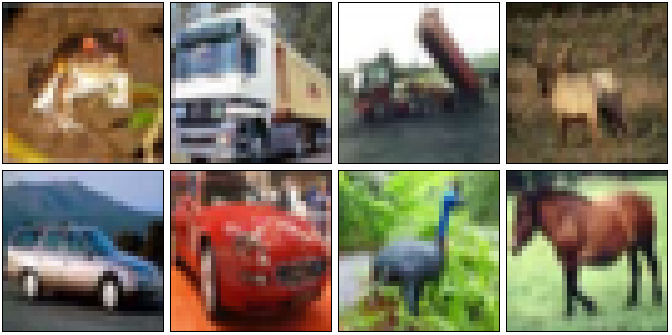

In [46]:
from pca import PCA
from pca import remove_high_freq, remove_low_freq

pca = PCA(n_components=1024, n_features=3*32*32)
pca.load_state_dict(torch.load("pca_cifar.pt", weights_only=True))

imgs = torch.stack([dataset[i][0] for i in range(8)]).cpu()
imgs.rgb(scale=5)

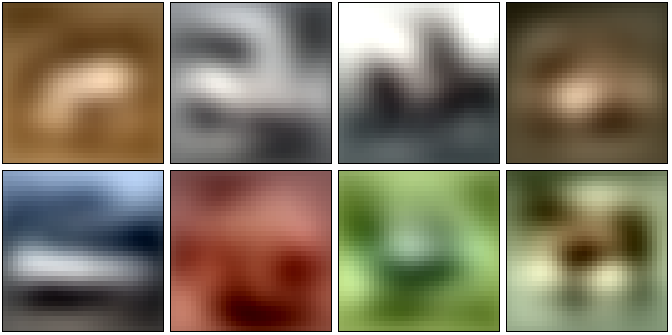

In [53]:
remove_high_freq(imgs, pca, var_threshold=0.2).rgb(scale=5)

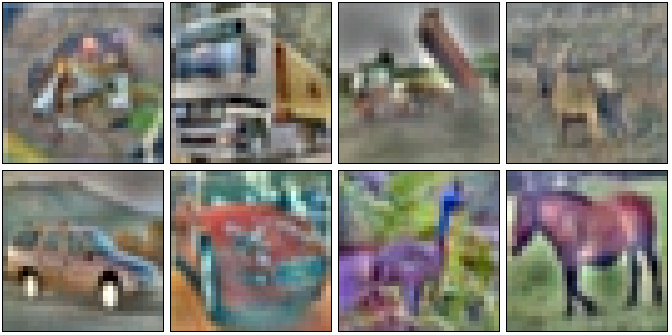

In [61]:
remove_low_freq(imgs, pca, var_threshold=0.8).rgb(scale=5)

In [71]:
from model import MAE_ViT

model = MAE_ViT()
predicted_img, masks = model(imgs)
img_high_freq = remove_low_freq(imgs, pca, var_threshold=0.5)

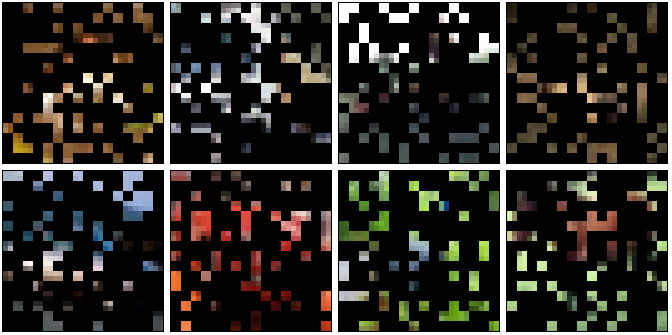

In [78]:
(imgs * (1-masks)).rgb(scale=5)

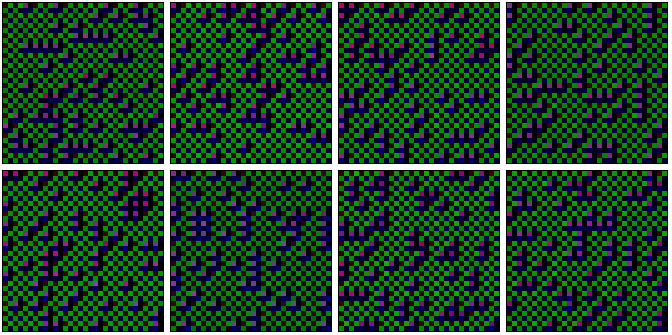

In [79]:
predicted_img.rgb(scale=5)

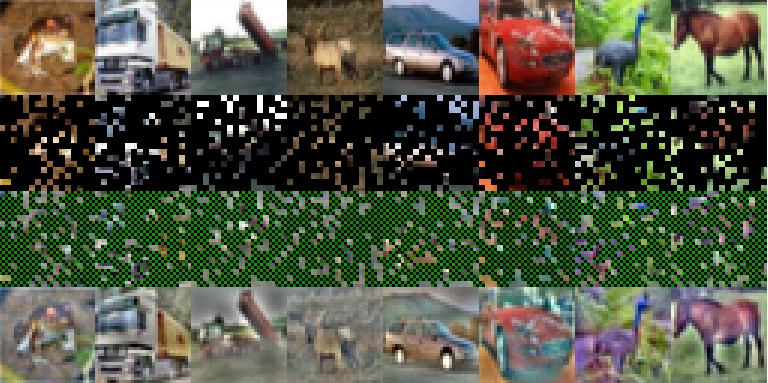

In [97]:
from utils import visualize

visualize(model, imgs, pca, var_threshold=0.8).rgb(scale=3)